### Retrieving ASCAT soil moisture data

- This notebook demonstrates a possible workflow to retrieve ASCAT soil moisture data

- The ASCAT data organized in cells on the so-called [Fibonacci Grid](https://github.com/TUW-GEO/fibgrid) is provided by the [TU Vienna Remote Sensing Research Group](https://www.tuwien.at/mg/geo/rs)

- We will focus on the regions of Buzi, Chokwé, Mabalane, Mabote, and Muanza in Mozambique


In [5]:
from datetime import datetime
from importlib import reload
from time import time
import netCDF4 as nc
import ascat.read_native.ragged_array_ts as rat
from ascat.read_native.ragged_array_ts import SwathFileCollection
from ascat.read_native import xarray_io
import numpy as np
import xarray as xr
import geopandas as gpd
import osmnx as ox
import os
import folium
import pandas as pd
import matplotlib.pyplot as plt

- The following code creates a dictonary with requested areas and their bounding boxes retrieved from OpenStreetMaps which we need for further steps

In [4]:
area_names =["Buzi","Chokwé","Mabalane","Mabote","Muanza"]


def bbox (area_names):


    area_dict = dict()

    for area_name in area_names:

        # Get GeoDataFrame from OpenStreetMap
        gdf = ox.geocode_to_gdf(area_name)
        # Get bounding box [minx, miny, maxx, maxy]
        bbox = gdf.total_bounds  

        # To get a proper bounding box for processing later on in the shape of [min_lon, max_lon, min_lat, max_lat]
        bbox= [float(bbox[0]), float(bbox[2]), float(bbox[1]), float(bbox[3])] 

        area_dict[area_name] = bbox
    
    return(area_dict)


areas = bbox(area_names)

print(areas)

{'Buzi': [33.8931254, 34.8127126, -20.5695588, -19.582687], 'Chokwé': [32.5596257, 33.5225846, -24.8651389, -24.1120627], 'Mabalane': [32.2377105, 33.2483723, -24.1967515, -22.9668694], 'Mabote': [33.1611587, 34.6342067, -22.9057726, -21.3023939], 'Muanza': [34.4736235, 35.6973266, -19.5313462, -18.6416478]}


- To be able to read ASCAT cells we use the function rat.CellFileCollection and further collection.read()
[(see documentation)](https://ascat.readthedocs.io/en/latest/xarray_readers_tutorial.html#working-with-collections-of-cell-files)

- The next code block filters ASCAT cells by bounding box and time frame and retrieves the the cell's soil moisture data

- Lastly each area, its soil moisture values and timestamps will be written to a csv file

### Here we should already rename average soil moisture!!

In [ ]:
import numpy as np
import pandas as pd
import os

# Paths and setup
cell_source = "~/lab/tree/shared/datasets/geo/sync/datasets/scat_ard/ascat_ssm_cdr_6.25km_h129"
output_dirs = ["~/drysat_jupyterhub/ascat_output"]


collection = rat.CellFileCollection.from_product_id(cell_source, product_id="H121_v1.0")


# Define time range
start_date = np.datetime64("2024-01-01")
end_date = np.datetime64("2024-12-31")

# Process each area
for area_name, bounds in areas.items():
    time_series_data = []

    # Add more IDs as needed
    for cell_id in [1524, 1525, 1526]:  
        data = collection.read(cell=cell_id)

        # Indexing values 
        data["location_id"].load()
        data["locationIndex"].load()
        data["location_id"] = data["location_id"][data["locationIndex"]]
        data["lon"] = data["lon"][data["locationIndex"]]
        data["lat"] = data["lat"][data["locationIndex"]]

        if "time" not in data.coords:
            data = data.set_index(time="time")

        # Filtering data by bounding box
        data_filt = data["surface_soil_moisture"].where(
            (data["lat"] >= bounds["lat_min"]) & (data["lat"] <= bounds["lat_max"]) &
            (data["lon"] >= bounds["lon_min"]) & (data["lon"] <= bounds["lon_max"]) &
            (data["time"] >= start_date) & (data["time"] <= end_date),
            drop=True
        )

        # This if loop can be deleted in order to get the raw ASCAT timestamps
        # Here the time gets rounded and the soil moisture value averaged
        if data_filt.size > 0:
            df = data_filt.to_dataframe().reset_index()
            df["time"] = pd.to_datetime(df["time"]).dt.floor("h")
            hourly_avg = df.groupby("time")["surface_soil_moisture"].mean().reset_index()
            time_series_data.append(hourly_avg)

    if time_series_data:

        # If there is no data overlap due to overlapping ASCAT cells it is not necessary to compute mean
        final_df = pd.concat(time_series_data).groupby("time")["surface_soil_moisture"].mean().reset_index()
        final_df.rename(columns={"time": "datetime", "surface_soil_moisture": "avg_soil_moisture"}, inplace=True)

        for output_dir in output_dirs:
            os.makedirs(output_dir, exist_ok=True)

            # Save ASCAT data
            ascat_path = os.path.join(output_dir, f"{area_name}_ascat.csv")
            final_df.to_csv(ascat_path, index=False)
            print(f"Saved ASCAT: {ascat_path}")

           


/home/jlinke/anaconda3/envs/drysat/lib/python3.13/site-packages/ascat/read_native/ragged_array_ts.py:945: UserWarning: Could not determine date range for collection 'ASCAT_Mozambique_data_fixed' from directory name. Using min/max datetime from files instead.
  warnings.warn(


Saved ASCAT: /home/jlinke/Documents/Geo/drysat/sync/test1/Buzi_ascat.csv
Saved ASCAT: /home/jlinke/Documents/Geo/drysat/sync/test2/Buzi_ascat.csv
Saved ASCAT: /home/jlinke/Documents/Geo/drysat/sync/test1/Chokwé_ascat.csv
Saved ASCAT: /home/jlinke/Documents/Geo/drysat/sync/test2/Chokwé_ascat.csv
Saved ASCAT: /home/jlinke/Documents/Geo/drysat/sync/test1/Mabalane_ascat.csv
Saved ASCAT: /home/jlinke/Documents/Geo/drysat/sync/test2/Mabalane_ascat.csv
Saved ASCAT: /home/jlinke/Documents/Geo/drysat/sync/test1/Mabote_ascat.csv
Saved ASCAT: /home/jlinke/Documents/Geo/drysat/sync/test2/Mabote_ascat.csv
Saved ASCAT: /home/jlinke/Documents/Geo/drysat/sync/test1/Muanza_ascat.csv
Saved ASCAT: /home/jlinke/Documents/Geo/drysat/sync/test2/Muanza_ascat.csv


- To get a better understanding for the data we take a quick look at the dataframe and plot the soil moisture data over time

In [ ]:
df = pd.read_csv("~/drysat_jupyterhub/ascat_output/Buzi_ascat.csv")

df

,datetime,avg_soil_moisture
0,2024-01-01 06:00:00,61.935113
1,2024-01-01 07:00:00,69.896708
2,2024-01-01 18:00:00,63.593815
3,2024-01-01 19:00:00,63.381158
4,2024-01-03 06:00:00,66.065519
...,...,...
310,2024-05-29 07:00:00,1.680000
311,2024-05-30 06:00:00,15.684437
312,2024-05-30 07:00:00,10.784242
313,2024-05-30 18:00:00,13.083781


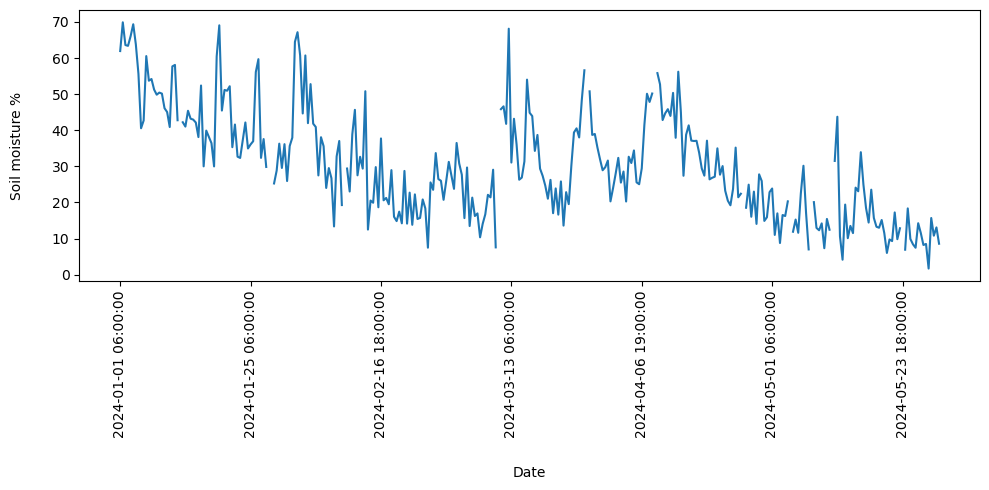

In [8]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

ax = df.plot(x="datetime", y="avg_soil_moisture", figsize=(10, 5))

# Set a higher tick frequency: one tick every X timestamps
#ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate and format
plt.xticks(rotation=90)
plt.xlabel("Date", labelpad=20)
plt.ylabel("Soil moisture %", labelpad=20)
ax.legend().remove()

plt.tight_layout()
plt.show()